In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv('/Users/joaop.cardoso/MestradoCD/TMBD/TMBD_M02/METRO Interstate/Metro_Interstate_Traffic_Volume.csv')
df.head()


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [20]:
df['date_time'] = pd.to_datetime(df['date_time'])

# Extract hour, day of the week, and month
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month

# Create a binary indicator for weekends
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

df['holiday'] = df['holiday'].notna()

df['near_holiday'] = df['holiday'].shift(-1).fillna(False) | df['holiday'].shift(1).fillna(False)

df = pd.get_dummies(df, columns=['day_of_week'], drop_first=True)

/var/folders/kl/mfb9z6_d1290hf_1b38hg6zr0000gn/T/ipykernel_39864/3463968891.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['near_holiday'] = df['holiday'].shift(-1).fillna(False) | df['holiday'].shift(1).fillna(False)


In [21]:
observed_data = df[['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 
                    'hour', 'month', 'is_weekend', 'near_holiday'] + 
                  [col for col in df.columns if 'day_of_week_' in col]].values


scaler = StandardScaler()
observed_data_scaled = scaler.fit_transform(observed_data)


In [22]:
# Split into train and test sets
train_data, test_data = train_test_split(observed_data_scaled, test_size=0.2, random_state=42)

# Define and fit the HMM
model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=500, random_state=42)
model.fit(train_data)

# Predict hidden states on the full dataset
hidden_states = model.predict(observed_data_scaled)
df['hidden_state'] = hidden_states

In [23]:
# Predict hidden states for the entire dataset
hidden_states = model.predict(observed_data_scaled)
print("Hidden states:\n", hidden_states)

# Output model parameters
print("Means:", model.means_)
print("Covariances:", model.covars_)

# Calculate log likelihood on the test set
log_likelihood = model.score(test_data)
print("Log likelihood:", log_likelihood)

Hidden states:
 [1 1 1 ... 0 0 0]
Means: [[-3.50431665e-01 -4.78280838e-03 -4.69864700e-03 -2.60064224e-02
  -4.81725732e-02 -6.24281852e-03  9.96513581e-03  1.58674819e+00
  -1.02752049e-02 -4.06854087e-01 -4.06854087e-01 -4.09758845e-01
  -4.09758845e-01 -4.05849181e-01 -4.05849181e-01 -4.06507689e-01
  -4.06507689e-01  1.02136281e+00  1.02136281e+00  1.02832060e+00
   1.02832060e+00 -4.06854087e-01 -4.06854087e-01 -4.09758845e-01
  -4.09758845e-01 -4.05849181e-01 -4.05849181e-01 -4.06507689e-01
  -4.06507689e-01  1.02136281e+00  1.02136281e+00  1.02832060e+00
   1.02832060e+00]
 [ 1.37774964e-01  1.01626974e-03  3.40281486e-03  1.09593082e-02
   1.81771923e-02  1.62301145e-03 -5.05913936e-03 -6.30219718e-01
   3.53203198e-03  1.65656584e-01  1.65656584e-01  1.62023521e-01
   1.62023521e-01  1.63508840e-01  1.63508840e-01  1.52197353e-01
   1.52197353e-01 -4.06334442e-01 -4.06334442e-01 -4.07754127e-01
  -4.07754127e-01  1.65656584e-01  1.65656584e-01  1.62023521e-01
   1.62023521e-0

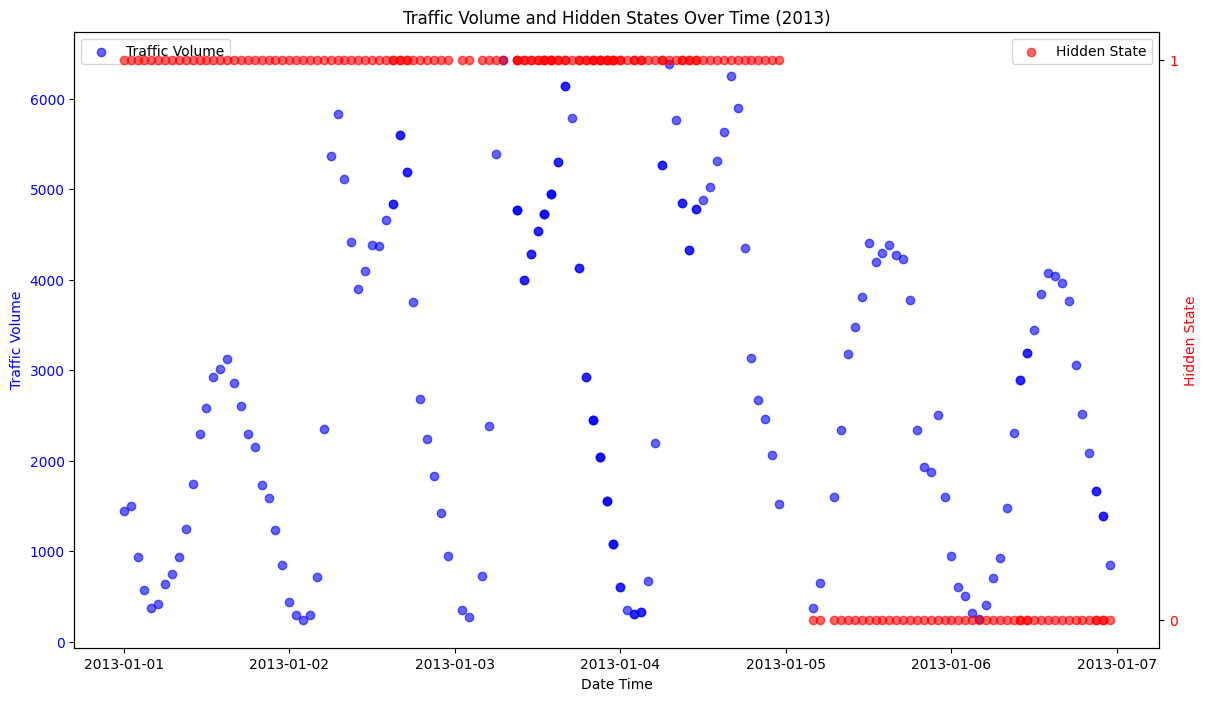

In [31]:
import matplotlib.pyplot as plt

# Ensure 'date_time' is in datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Filter the DataFrame for the year 2013
df_2013 = df[(df['date_time'] >= '2013-01-01') & (df['date_time'] < '2013-01-07')]

# Plot traffic volume over time with hidden states as a secondary y-axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot traffic volume as dots on the primary y-axis
ax1.scatter(df_2013['date_time'], df_2013['traffic_volume'], color='b', label='Traffic Volume', alpha=0.6)
ax1.set_xlabel('Date Time')
ax1.set_ylabel('Traffic Volume', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for hidden states
ax2 = ax1.twinx()
ax2.scatter(df_2013['date_time'], df_2013['hidden_state'], color='r', label='Hidden State', alpha=0.6)
ax2.set_ylabel('Hidden State', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_yticks([0, 1])  # Assuming there are only two hidden states (0 and 1)

# Add legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Display the plot
plt.title('Traffic Volume and Hidden States Over Time (2013)')
plt.show()
